In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from fastai import *
from fastai.text import *
import sys,os,os.path
import re
import pickle

In [3]:
#export
bs=8


In [27]:
#export
path = "/home/jupyter/mrdbarros/csgo_analyze/data/Raw"

In [28]:
data_lm=None

In [29]:
#export
data_lm = (TextList.from_folder(path)
            .filter_by_folder() 
            #.filter_by_folder(include=["de_dust2","de_inferno","de_mirage","de_nuke","de_overpass","de_train","de_vertigo","de_cache"]) 
            .split_by_rand_pct(0.2)
            .label_for_lm()           
            .databunch(bs=bs, num_workers=1))

len(data_lm.vocab.itos),len(data_lm.train_ds)

(816, 256)

In [30]:
data_lm.vocab.itos

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'x_coor',
 'y_coor',
 'z_coor',
 '0',
 't_pickup',
 'ct_pickup',
 '-8',
 'ct_2_pos',
 'ct_3_pos',
 'tr_1_pos',
 'tr_5_pos',
 'tr_4_pos',
 'ct_5_pos',
 'tr_2_pos',
 'ct_1_pos',
 'ct_4_pos',
 'tr_3_pos',
 '6',
 '-20',
 'tr_id_2',
 'tr_id_1',
 'tr_id_5',
 'tr_id_4',
 'tr_id_3',
 '1',
 'ct_id_5',
 'ct_id_1',
 'ct_id_3',
 'ct_id_2',
 '4',
 'ct_id_4',
 '-10',
 '-1',
 '8',
 '-6',
 'flashbang',
 '-5',
 '-2',
 '-3',
 'knife',
 '3',
 '7',
 '-17',
 '5',
 'smoke_grenade',
 '2',
 '-4',
 '-13',
 'flash',
 '-11',
 '-7',
 '24',
 'damage_25',
 '23',
 '-12',
 'smoke_start',
 '12',
 '21',
 '-31',
 '-9',
 'kevlar_+_helmet',
 '-15',
 '14',
 'damage_20',
 'glock_18',
 'inferno_start',
 '-18',
 '9',
 'p2000',
 '-19',
 '588',
 '-38',
 '16',
 'ct_kill',
 '26',
 '25',
 '10',
 '17',
 '19',
 't_kill',
 '22',
 '29',
 '20',
 'he_grenade',
 '-14',
 '27',
 '28',
 'molotov',
 '11',
 'ak_47',
 'c4',
 '-16',
 '-30',
 '-21',
 '-48'

In [31]:
data_lm

TextLMDataBunch;

Train: LabelList (256 items)
x: LMTextList
xxbos de_mirage round_start ct_0 t_0 ct_pickup ct_id_3 knife ct_pickup ct_id_3 p2000 ct_pickup ct_id_4 knife ct_pickup ct_id_4 p2000 t_pickup tr_id_4 knife t_pickup tr_id_4 glock_18 t_pickup tr_id_5 knife t_pickup tr_id_5 glock_18 ct_pickup ct_id_5 knife ct_pickup ct_id_5 p2000 ct_pickup ct_id_1 knife ct_pickup ct_id_1 p2000 t_pickup tr_id_2 knife t_pickup tr_id_2 glock_18 ct_pickup ct_id_2 knife ct_pickup ct_id_2 p2000 t_pickup tr_id_3 knife t_pickup tr_id_3 glock_18 t_pickup tr_id_1 knife t_pickup tr_id_1 glock_18 t_pickup tr_id_2 c4 t_pickup tr_id_5 kevlar_vest ct_pickup ct_id_1 kevlar_vest ct_pickup ct_id_2 kevlar_vest ct_pickup ct_id_3 kevlar_vest tr_4_pos x_coor 60 y_coor -10 z_coor -8 tr_5_pos x_coor 68 y_coor 0 z_coor -8 tr_1_pos x_coor 60 y_coor -15 z_coor -8 tr_2_pos x_coor 68 y_coor -5 z_coor -8 tr_3_pos x_coor 56 y_coor -12 z_coor -8 ct_3_pos x_coor -95 y_coor -98 z_coor -13 ct_1_pos x_coor -81 y_coor -103 z_coor 

In [32]:
#export
learn_lm = language_model_learner(data_lm, TransformerXL, drop_mult=1.,pretrained=False).to_fp16()

In [24]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


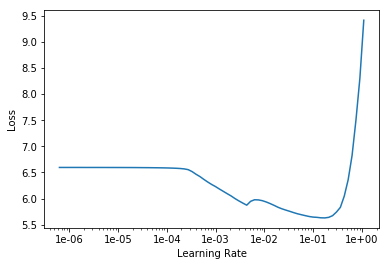

In [25]:
learn_lm.recorder.plot()

In [35]:
lr=1e-6

In [4]:
import warnings
warnings.filterwarnings(action='once')

In [37]:
#export
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.353163,1.367008,0.620320,38:25


/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


In [15]:
learn_lm.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.731214,1.701956,0.636164,13:54
1,1.652582,1.635012,0.642414,13:58


In [40]:
#export
models_path="/home/jupyter/mrdbarros/csgo_analyze/data/models"
learn_lm.data.vocab.save(models_path+"/fine_tuned_enc_vocab_Transf2.pkl")
learn_lm.save_encoder(models_path+"/fine_tuned_enc_Transf2")
learn_lm.save(models_path+"/fine_tuned_Transf2")
data_lm.export(models_path+"/fine_tuned_Transf2")

In [11]:
learn_lm = None

clas_vocab=data_lm.vocab
data_lm=None
torch.cuda.empty_cache()

In [41]:
path_data="/home/jupyter/mrdbarros/csgo_analyze/data"

In [50]:
#export
def cleanCSGOMatchFile(extractedMatchFilePath):
    f=open(extractedMatchFilePath,'r')
    contents = f.read()
    if len(contents)>50:
        re_map = re.compile("de_.*? ")
        #pdb.set_trace()
        current_map = re.findall(re_map,contents)[0]
        #print(contents)
        re_round = re.compile("(round_start(?! round_start).*?round_end_official)")
        all_rounds=re.findall(re_round,contents)
        labeled_samples=splitFullRounds(all_rounds,current_map)
        return labeled_samples
    else:
        !rm -f {extractedMatchFilePath}
    

In [62]:
#export
def splitFullRounds(fullRoundsList, current_map):
    labeled_samples=[]
    invalid_split_round_events=["t_round_win","ct_round_win","round_start","match_started"]
    for one_round in fullRoundsList:
        sub_rounds = splitSingleRound(one_round)
        #pdb.set_trace()
        for sub_round in sub_rounds:
            
            invalid_state_test=any(split_round_event in sub_round[1:] for split_round_event in invalid_split_round_events)
            if not invalid_state_test:
                winner = "ct" if "ct_round_win" in one_round else "t"
                labeled_samples.append([current_map+" "+sub_round,winner])
 
    return labeled_samples
        
        #print(x_events)

In [63]:
def splitSingleRound(one_round):
    re_sub_rounds= re.compile(r'(.*? time_event_\d+)')
    complete_sub_rounds=[]
    sub_rounds = re.findall(re_sub_rounds,one_round)
    full_current_round=""
    for sub_round in sub_rounds:
        full_current_round+=sub_round
        complete_sub_rounds.append(full_current_round)
    return complete_sub_rounds

In [64]:
import pdb

In [65]:
delete_path = "/home/jupyter/mrdbarros/csgo_analyze/data/Processed/*"
print(delete_path)
!rm -rf {delete_path}

/home/jupyter/mrdbarros/csgo_analyze/data/Processed/*


In [66]:
path_data="/home/jupyter/mrdbarros/csgo_analyze/data"

In [67]:
#export


top_folders = ["train","valid"]
sub_folders  = ["t","ct"]
for top_folder in top_folders:
    for sub_folder in sub_folders:
        new_folder = path_data + "/Processed/" + top_folder + "/" + sub_folder
        !mkdir -p {new_folder}
valid_size = 0.2
for root, dir_names, files in os.walk(path_data+'/Raw'):
    for file in files:
        if ".txt" in file:
            #pdb.set_trace()
            parsed_match=cleanCSGOMatchFile(root+"/"+file)
            round_id=0
            folder = "valid" if random.random() < 0.2 else "train"
            if parsed_match:
                for parsed_round in parsed_match:
                    f= open(path_data+'/Processed/'+folder+"/"+parsed_round[1]+'/'+"r"+str(round_id)+"_"+file,"w+")
                    round_id+=1
                    f.write(parsed_round[0])
                    f.close()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_mirage/de_mirage_42.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_mirage/de_mirage_46.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_mirage/de_mirage_226.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_mirage/de_mirage_36.txt'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_mirage/de_mirage_214.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_mirage/de_mirage_301.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_mirage/de_mirage_284.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_mirage/de_mirage_255.t

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_mirage/de_mirage_234.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_mirage/de_mirage_141.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_mirage/de_mirage_57.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_mirage/de_mirage_43.txt

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_train/de_train_77.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_train/de_train_236.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_train/de_train_142.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_train/de_train_123.txt' mode=

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_train/de_train_309.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_train/de_train_183.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_train/de_train_289.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_train/de_train_219.txt' mode

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_overpass/de_overpass_98.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_overpass/de_overpass_179.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_overpass/de_overpass_47.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_overpass/de_

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_overpass/de_overpass_51.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_overpass/de_overpass_294.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_overpass/de_overpass_224.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_overpass/de

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_nuke/de_nuke_296.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_nuke/de_nuke_317.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_nuke/de_nuke_140.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_nuke/de_nuke_258.txt' mode='r' enc

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_nuke/de_nuke_144.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_nuke/de_nuke_231.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_nuke/de_nuke_38.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_nuke/de_nuke_49.txt' mode='r' encod

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_dust2/de_dust2_60.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_dust2/de_dust2_274.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_dust2/de_dust2_89.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_dust2/de_dust2_81.txt' mode='r

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_dust2/de_dust2_241.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_dust2/de_dust2_266.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_dust2/de_dust2_265.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_dust2/de_dust2_310.txt' mode

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_inferno/de_inferno_185.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_inferno/de_inferno_197.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_inferno/de_inferno_135.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_inferno/de_infer

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_inferno/de_inferno_239.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_inferno/de_inferno_182.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_inferno/de_inferno_276.txt' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jupyter/mrdbarros/csgo_analyze/data/Raw/de_inferno/de_infer

In [4]:
models_path="/home/jupyter/mrdbarros/csgo_analyze/data/models"
path_data='/home/jupyter/mrdbarros/csgo_analyze/data'
file = open(models_path+"/fine_tuned_enc_vocab_Transf2.pkl","rb")


In [5]:
vocab=Vocab(pickle.load(file))


In [6]:
file.close()

In [7]:
#export
def valid_train_split(file_name):
    #pdb.set_trace()
    return True if file_name.parents[1].stem == "valid" else False


data_clas = (TextList.from_folder(path_data+"/Processed", vocab=vocab)
             .filter_by_folder(include=["valid","train"]) 
             .split_by_valid_func(valid_train_split)
             .label_from_folder(classes=['t', 'ct'])
             .databunch(bs=bs, num_workers=4))

In [8]:
models_path

'/home/jupyter/mrdbarros/csgo_analyze/data/models'

In [10]:
data_clas

TextClasDataBunch;

Train: LabelList (85963 items)
x: TextList
xxbos de_overpass round_start ct_0 t_1 ct_pickup ct_id_1 knife ct_pickup ct_id_1 p2000 ct_pickup ct_id_4 knife ct_pickup ct_id_4 p2000 ct_pickup ct_id_5 knife ct_pickup ct_id_5 p2000 ct_pickup ct_id_2 knife ct_pickup ct_id_2 p2000 ct_pickup ct_id_3 knife ct_pickup ct_id_3 p2000 t_pickup tr_id_1 c4 t_pickup tr_id_2 kevlar_+_helmet t_pickup tr_id_2 sg_553 t_pickup tr_id_3 kevlar_+_helmet t_pickup tr_id_3 ak_47 t_pickup tr_id_2 smoke_grenade t_pickup tr_id_3 smoke_grenade t_pickup tr_id_2 he_grenade t_pickup tr_id_2 flashbang tr_2_pos x_coor -76 y_coor -162 z_coor 14 tr_1_pos x_coor -69 y_coor -159 z_coor 14 tr_5_pos x_coor -72 y_coor -163 z_coor 14 tr_3_pos x_coor -66 y_coor -163 z_coor 14 tr_4_pos x_coor -68 y_coor -156 z_coor 14 ct_4_pos x_coor -108 y_coor 44 z_coor 24 ct_1_pos x_coor -109 y_coor 40 z_coor 23 ct_2_pos x_coor -119 y_coor 40 z_coor 23 ct_3_pos x_coor -112 y_coor 41 z_coor 23 ct_5_pos x_coor -118 y_coor 36 z_c

In [74]:
data_clas.show_batch()

text,target
xxbos de_inferno round_start ct_0 t_0 ct_pickup ct_id_0 knife ct_pickup ct_id_0 p2000 t_pickup tr_id_0 knife t_pickup tr_id_0 glock_18 ct_pickup ct_id_0 knife ct_pickup ct_id_0 p2000 t_pickup tr_id_0 knife t_pickup tr_id_0 glock_18 ct_pickup ct_id_0 knife ct_pickup ct_id_0 p2000 t_pickup tr_id_0 knife t_pickup tr_id_0 glock_18 freeze_time_end time_event_0 t_pickup tr_id_0 knife t_pickup tr_id_0 glock_18 ct_pickup ct_id_0 knife ct_pickup ct_id_0 p2000 t_pickup tr_id_0 knife t_pickup tr_id_0 glock_18 ct_pickup ct_id_0 knife ct_pickup ct_id_0 p2000 time_event_4 time_event_8 time_event_12,ct
xxbos de_dust2 round_start ct_10 t_12 ct_pickup ct_id_5 knife ct_pickup ct_id_5 p2000 ct_pickup ct_id_4 knife ct_pickup ct_id_4 p2000 t_pickup tr_id_3 knife t_pickup tr_id_3 glock_18 ct_pickup ct_id_1 knife ct_pickup ct_id_1 p2000 ct_pickup ct_id_3 knife ct_pickup ct_id_3 p2000 ct_pickup ct_id_2 knife ct_pickup ct_id_2 p2000 t_pickup tr_id_1 c4 t_pickup tr_id_2 molotov t_pickup tr_id_2 flashbang t_pickup tr_id_2 flashbang t_pickup tr_id_3 kevlar_+_helmet t_pickup tr_id_3 ak_47 ct_pickup ct_id_2 kevlar_+_helmet ct_pickup ct_id_2 m4a4 ct_pickup ct_id_2 defuse_kit t_pickup tr_id_3,t
xxbos de_mirage round_start ct_1 t_3 ct_pickup ct_id_2 knife ct_pickup ct_id_2 p2000 ct_pickup ct_id_3 knife ct_pickup ct_id_3 p2000 ct_pickup ct_id_1 knife ct_pickup ct_id_1 p2000 t_pickup tr_id_5 c4 tr_5_pos x_coor 64 y_coor -12 z_coor -8 tr_4_pos x_coor 56 y_coor -8 z_coor -8 tr_1_pos x_coor 56 y_coor 1 z_coor -8 tr_2_pos x_coor 68 y_coor 0 z_coor -8 tr_3_pos x_coor 60 y_coor 0 z_coor -8 ct_3_pos x_coor -77 y_coor -90 z_coor -13 ct_4_pos x_coor,t
xxbos de_inferno round_start ct_4 t_9 ct_pickup ct_id_1 knife ct_pickup ct_id_1 p2000 t_pickup tr_id_5 knife t_pickup tr_id_5 glock_18 t_pickup tr_id_1 knife t_pickup tr_id_1 glock_18 ct_pickup ct_id_5 knife ct_pickup ct_id_5 p2000 t_pickup tr_id_2 knife t_pickup tr_id_2 glock_18 t_pickup tr_id_4 knife t_pickup tr_id_4 glock_18 t_pickup tr_id_3 knife t_pickup tr_id_3 glock_18 ct_pickup ct_id_4 knife ct_pickup ct_id_4 p2000 t_pickup tr_id_3 c4 tr_3_pos x_coor -82 y_coor 27 z_coor -3 tr_2_pos x_coor -84 y_coor 24 z_coor -3,ct
xxbos de_inferno round_start ct_0 t_4 t_pickup tr_id_5 knife t_pickup tr_id_5 glock_18 t_pickup tr_id_3 knife t_pickup tr_id_3 glock_18 ct_pickup ct_id_1 knife ct_pickup ct_id_1 p2000 ct_pickup ct_id_4 knife ct_pickup ct_id_4 p2000 ct_pickup ct_id_2 knife ct_pickup ct_id_2 p2000 ct_pickup ct_id_5 knife ct_pickup ct_id_5 p2000 ct_pickup ct_id_3 knife ct_pickup ct_id_3 p2000 t_pickup tr_id_4 c4 t_pickup tr_id_2 smoke_grenade t_pickup tr_id_2 he_grenade t_pickup tr_id_2 molotov ct_pickup ct_id_3 m4a4 t_pickup tr_id_1 molotov tr_3_pos x_coor -83 y_coor 14,t


In [20]:
#export
learn = text_classifier_learner(data_clas, TransformerXL,drop_mult=1).to_fp16()
#pdb.set_trace()



In [21]:
learn.load_encoder(models_path+'/fine_tuned_enc_Transf2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (85963 items)
x: TextList
xxbos de_overpass round_start ct_0 t_1 ct_pickup ct_id_1 knife ct_pickup ct_id_1 p2000 ct_pickup ct_id_4 knife ct_pickup ct_id_4 p2000 ct_pickup ct_id_5 knife ct_pickup ct_id_5 p2000 ct_pickup ct_id_2 knife ct_pickup ct_id_2 p2000 ct_pickup ct_id_3 knife ct_pickup ct_id_3 p2000 t_pickup tr_id_1 c4 t_pickup tr_id_2 kevlar_+_helmet t_pickup tr_id_2 sg_553 t_pickup tr_id_3 kevlar_+_helmet t_pickup tr_id_3 ak_47 t_pickup tr_id_2 smoke_grenade t_pickup tr_id_3 smoke_grenade t_pickup tr_id_2 he_grenade t_pickup tr_id_2 flashbang tr_2_pos x_coor -76 y_coor -162 z_coor 14 tr_1_pos x_coor -69 y_coor -159 z_coor 14 tr_5_pos x_coor -72 y_coor -163 z_coor 14 tr_3_pos x_coor -66 y_coor -163 z_coor 14 tr_4_pos x_coor -68 y_coor -156 z_coor 14 ct_4_pos x_coor -108 y_coor 44 z_coor 24 ct_1_pos x_coor -109 y_coor 40 z_coor 23 ct_2_pos x_coor -119 y_coor 40 z_coor 23 ct_3_pos x_coor -112 y_coor 41 z_coor 23 ct_5_pos x_coor -1

In [19]:
learn.load('class_before_unf_fp16_opt')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (85963 items)
x: TextList
xxbos de_overpass round_start ct_0 t_1 ct_pickup ct_id_1 knife ct_pickup ct_id_1 p2000 ct_pickup ct_id_4 knife ct_pickup ct_id_4 p2000 ct_pickup ct_id_5 knife ct_pickup ct_id_5 p2000 ct_pickup ct_id_2 knife ct_pickup ct_id_2 p2000 ct_pickup ct_id_3 knife ct_pickup ct_id_3 p2000 t_pickup tr_id_1 c4 t_pickup tr_id_2 kevlar_+_helmet t_pickup tr_id_2 sg_553 t_pickup tr_id_3 kevlar_+_helmet t_pickup tr_id_3 ak_47 t_pickup tr_id_2 smoke_grenade t_pickup tr_id_3 smoke_grenade t_pickup tr_id_2 he_grenade t_pickup tr_id_2 flashbang tr_2_pos x_coor -76 y_coor -162 z_coor 14 tr_1_pos x_coor -69 y_coor -159 z_coor 14 tr_5_pos x_coor -72 y_coor -163 z_coor 14 tr_3_pos x_coor -66 y_coor -163 z_coor 14 tr_4_pos x_coor -68 y_coor -156 z_coor 14 ct_4_pos x_coor -108 y_coor 44 z_coor 24 ct_1_pos x_coor -109 y_coor 40 z_coor 23 ct_2_pos x_coor -119 y_coor 40 z_coor 23 ct_3_pos x_coor -112 y_coor 41 z_coor 23 ct_5_pos x_coor -1

In [76]:
torch.cuda.empty_cache()

In [72]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


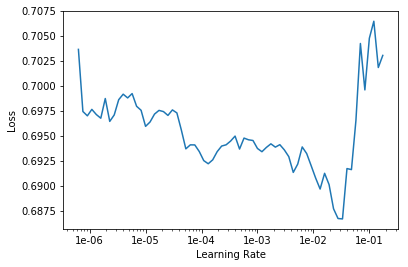

In [73]:
learn.recorder.plot(skip_end = 15)

In [22]:
lr=1e-2

In [ ]:
#export
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time


In [77]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.627815,0.640740,0.649410,08:24


In [29]:
learn.fit_one_cycle(1, lr/10)

epoch,train_loss,valid_loss,accuracy,time
0,0.590303,0.622199,0.638574,03:17


In [79]:
learn.save("class_before_unf_fp16_opt")

In [11]:
learn.unfreeze()

In [48]:
learn.freeze_to(-2)

In [12]:
learn.fit_one_cycle(1,max_lr=slice(1e-10,1e-9))

epoch,train_loss,valid_loss,accuracy,time
0,0.604806,0.697485,0.644596,3:49:56


In [13]:
learn.save("class_after_unf_fp16")

In [14]:
test_round = "de_mirage  round_start ct_0 t_2 ct_pickup ct_id_5 knife ct_pickup ct_id_5 p2000 t_pickup tr_id_2 knife t_pickup tr_id_2 glock_18 t_pickup tr_id_5 knife t_pickup tr_id_5 glock_18 ct_pickup ct_id_4 knife ct_pickup ct_id_4 p2000 t_pickup tr_id_1 knife t_pickup tr_id_1 glock_18 ct_pickup ct_id_3 knife ct_pickup ct_id_3 p2000 ct_pickup ct_id_2 knife ct_pickup ct_id_2 p2000 t_pickup tr_id_2 c4 tr_2_pos x_coor 68 y_coor -15 z_coor -8 tr_1_pos x_coor 60 y_coor -10 z_coor -8 tr_5_pos x_coor 56 y_coor -12 z_coor -8 tr_3_pos x_coor 60 y_coor 0 z_coor -8 tr_4_pos x_coor 68 y_coor -10 z_coor -8 ct_3_pos x_coor -91 y_coor -94 z_coor -13 ct_1_pos x_coor -77 y_coor -98 z_coor -13 ct_2_pos x_coor -82 y_coor -90 z_coor -13 ct_5_pos x_coor -82 y_coor -98 z_coor -13 ct_4_pos x_coor -79 y_coor -86 z_coor -13 time_event_40 t_pickup tr_id_4 flashbang t_pickup tr_id_4 molotov ct_pickup ct_id_5 aug t_pickup tr_id_2 kevlar_+_helmet t_pickup tr_id_2 ak_47 ct_pickup ct_id_5 kevlar_vest t_pickup tr_id_2 molotov t_pickup tr_id_2 smoke_grenade ct_pickup ct_id_5 smoke_grenade t_pickup tr_id_2 flashbang t_pickup tr_id_1 ak_47 ct_pickup ct_id_1 kevlar_+_helmet ct_pickup ct_id_1 defuse_kit ct_pickup ct_id_5 flashbang ct_pickup ct_id_5 flashbang ct_pickup ct_id_1 incendiary_grenade t_pickup tr_id_2 flashbang ct_pickup ct_id_1 smoke_grenade ct_pickup ct_id_1 he_grenade ct_pickup ct_id_1 flashbang ct_pickup ct_id_4 kevlar_vest t_pickup tr_id_1 kevlar_+_helmet t_pickup tr_id_4 ak_47 t_pickup tr_id_1 molotov t_pickup tr_id_5 ak_47 t_pickup tr_id_1 smoke_grenade ct_pickup ct_id_4 aug t_pickup tr_id_1 flashbang t_pickup tr_id_1 flashbang ct_pickup ct_id_4 flashbang ct_pickup ct_id_4 smoke_grenade t_pickup tr_id_5 kevlar_+_helmet t_pickup tr_id_5 molotov ct_pickup ct_id_2 aug t_pickup tr_id_5 smoke_grenade t_pickup tr_id_5 flashbang t_pickup tr_id_5 flashbang time_event_44 ct_pickup ct_id_2 kevlar_vest t_pickup tr_id_3 smoke_grenade ct_pickup ct_id_2 smoke_grenade t_pickup tr_id_3 molotov t_pickup tr_id_3 flashbang t_pickup tr_id_3 flashbang ct_pickup ct_id_2 flashbang ct_pickup ct_id_2 flashbang ct_pickup ct_id_3 awp ct_pickup ct_id_3 smoke_grenade freeze_time_end tr_3_pos x_coor 60 y_coor 0 z_coor -8 tr_4_pos x_coor 68 y_coor -10 z_coor -8 tr_5_pos x_coor 56 y_coor -12 z_coor -8 tr_1_pos x_coor 60 y_coor -10 z_coor -8 tr_2_pos x_coor 68 y_coor -15 z_coor -8 ct_3_pos x_coor -91 y_coor -94 z_coor -13 ct_2_pos x_coor -82 y_coor -89 z_coor -13 ct_5_pos x_coor -82 y_coor -98 z_coor -13 ct_1_pos x_coor -77 y_coor -98 z_coor -13 time_event_0 t_pickup tr_id_5 c4 t_pickup tr_id_3 mac_10 tr_3_pos x_coor 58 y_coor -40 z_coor -12 tr_4_pos x_coor 68 y_coor -25 z_coor -8 tr_5_pos x_coor 55 y_coor -49 z_coor -11 tr_2_pos x_coor 56 y_coor -51 z_coor -7 tr_1_pos x_coor 60 y_coor -50 z_coor -13 ct_1_pos x_coor -80 y_coor -58 z_coor -12 ct_3_pos x_coor -57 y_coor -115 z_coor -8 ct_5_pos x_coor -51 y_coor -119 z_coor -8 ct_2_pos x_coor -77 y_coor -50 z_coor -10 ct_4_pos x_coor -72 y_coor -49 z_coor -8 flash ct_id_5 x_coor 0 y_coor -2 z_coor 1 tr_5_pos x_coor 45 y_coor -51 z_coor -12 tr_2_pos x_coor 56 y_coor -62 z_coor -5 tr_1_pos x_coor 40 y_coor -67 z_coor -5 tr_3_pos x_coor 57 y_coor -59 z_coor -10 tr_4_pos x_coor 65 y_coor -67 z_coor -8 ct_1_pos x_coor -95 y_coor -16 z_coor -6 ct_4_pos x_coor -47 y_coor -26 z_coor -3 ct_2_pos x_coor -49 y_coor -69 z_coor -8 ct_3_pos x_coor -37 y_coor -83 z_coor -8 ct_5_pos x_coor -43 y_coor -115 z_coor -8 time_event_4 smoke_start tr_id_4 x_coor 0 y_coor -1 z_coor 0 flash tr_id_4 x_coor 0 y_coor -1 z_coor 0 tr_2_pos x_coor 38 y_coor -74 z_coor -5 tr_1_pos x_coor 40 y_coor -73 z_coor -5 tr_3_pos x_coor 57 y_coor -59 z_coor -10 tr_4_pos x_coor 50 y_coor -95 z_coor -3 ct_2_pos x_coor -30 y_coor -65 z_coor -8 ct_4_pos x_coor -40 y_coor -16 z_coor -8 ct_5_pos x_coor -49 y_coor -125 z_coor -8 ct_1_pos x_coor -104 y_coor 19 z_coor -7 ct_3_pos x_coor -39 y_coor -48 z_coor -8 smoke_start ct_id_5 x_coor 0 y_coor -3 z_coor 0 tr_2_pos x_coor 40 y_coor -78 z_coor -5 tr_4_pos x_coor 36 y_coor -108 z_coor -1 tr_1_pos x_coor 40 y_coor -74 z_coor -5 ct_2_pos x_coor -30 y_coor -59 z_coor -8 ct_3_pos x_coor -47 y_coor -68 z_coor -8 ct_1_pos x_coor -111 y_coor 40 z_coor -6 ct_4_pos x_coor -39 y_coor -16 z_coor -8 ct_5_pos x_coor -47 y_coor -127 z_coor -8 time_event_8 inferno_start ct_id_1 x_coor -2 y_coor 1 z_coor 0 tr_2_pos x_coor 40 y_coor -78 z_coor -5 tr_1_pos x_coor 40 y_coor -74 z_coor -5 tr_4_pos x_coor 35 y_coor -108 z_coor -1 tr_5_pos x_coor 46 y_coor -53 z_coor -13 ct_2_pos x_coor -26 y_coor -53 z_coor -8 ct_5_pos x_coor -45 y_coor -129 z_coor -8 ct_1_pos x_coor -105 y_coor 35 z_coor 0 ct_4_pos x_coor -39 y_coor -16 z_coor -8 ct_3_pos x_coor -52 y_coor -69 z_coor -8 smoke_start ct_id_3 x_coor 0 y_coor -5 z_coor 0 tr_4_pos x_coor 28 y_coor -111 z_coor -1 tr_2_pos x_coor 40 y_coor -78 z_coor -5 tr_5_pos x_coor 45 y_coor -51 z_coor -12 ct_1_pos x_coor -93 y_coor 35 z_coor -2 ct_3_pos x_coor -73 y_coor -55 z_coor -8 ct_2_pos x_coor -26 y_coor -53 z_coor -8 ct_4_pos x_coor -39 y_coor 0 z_coor -8 ct_5_pos x_coor -30 y_coor -119 z_coor -8 time_event_12 smoke_start ct_id_1 x_coor -3 y_coor 1 z_coor 0 tr_4_pos x_coor 28 y_coor -111 z_coor -1 tr_2_pos x_coor 40 y_coor -78 z_coor -5 tr_5_pos x_coor 45 y_coor -51 z_coor -10 ct_2_pos x_coor -26 y_coor -54 z_coor -8 ct_4_pos x_coor -58 y_coor 10 z_coor -8 ct_5_pos x_coor -10 y_coor -110 z_coor -8 ct_1_pos x_coor -77 y_coor 43 z_coor 0 ct_3_pos x_coor -74 y_coor -101 z_coor -13 tr_5_pos x_coor 51 y_coor -62 z_coor -5 tr_3_pos x_coor 44 y_coor -61 z_coor -5 tr_4_pos x_coor 14 y_coor -117 z_coor -1 tr_2_pos x_coor 37 y_coor -60 z_coor -2 tr_1_pos x_coor 37 y_coor -60 z_coor -5 ct_2_pos x_coor -32 y_coor -62 z_coor -6 ct_4_pos x_coor -80 y_coor 21 z_coor -8 ct_3_pos x_coor -52 y_coor -116 z_coor -8 ct_5_pos x_coor -14 y_coor -120 z_coor -8 time_event_16 inferno_start tr_id_4 x_coor 0 y_coor -4 z_coor 0 smoke_start tr_id_5 x_coor -2 y_coor -6 z_coor 0 smoke_start tr_id_3 x_coor -1 y_coor -4 z_coor 0 smoke_start tr_id_1 x_coor -1 y_coor -4 z_coor 0 tr_3_pos x_coor 41 y_coor -62 z_coor -5 tr_2_pos x_coor 32 y_coor -62 z_coor -4 tr_4_pos x_coor 4 y_coor -118 z_coor -1 tr_5_pos x_coor 41 y_coor -61 z_coor -2 ct_1_pos x_coor -91 y_coor 37 z_coor -2 ct_2_pos x_coor -43 y_coor -65 z_coor -8 ct_4_pos x_coor -107 y_coor 31 z_coor -7 ct_3_pos x_coor -47 y_coor -127 z_coor -8 ct_5_pos x_coor -14 y_coor -120 z_coor -8 inferno_start tr_id_3 x_coor 0 y_coor -3 z_coor 0 inferno_start tr_id_2 x_coor -1 y_coor -4 z_coor 0 flash tr_id_1 x_coor 0 y_coor -4 z_coor 0 smoke_start ct_id_2 x_coor 0 y_coor -5 z_coor 0 inferno_start tr_id_5 x_coor -1 y_coor -4 z_coor 0 tr_5_pos x_coor 41 y_coor -51 z_coor -12 tr_4_pos x_coor 13 y_coor -116 z_coor -1 tr_2_pos x_coor 28 y_coor -74 z_coor -12 tr_1_pos x_coor 26 y_coor -82 z_coor -13 tr_3_pos x_coor 43 y_coor -62 z_coor -5 ct_3_pos x_coor -48 y_coor -126 z_coor -5 ct_1_pos x_coor -104 y_coor 32 z_coor -1 ct_2_pos x_coor -37 y_coor -69 z_coor -8 ct_4_pos x_coor -99 y_coor -12 z_coor -7 time_event_20 flash tr_id_3 x_coor 1 y_coor -4 z_coor 0 flash tr_id_5 x_coor 0 y_coor -3 z_coor 0 flash tr_id_5 x_coor 0 y_coor -3 z_coor 0 flash tr_id_3 x_coor 0 y_coor -4 z_coor 1 tr_5_pos x_coor 25 y_coor -78 z_coor -13 tr_1_pos x_coor -3 y_coor -75 z_coor -8 tr_3_pos x_coor 29 y_coor -75 z_coor -13 tr_4_pos x_coor 5 y_coor -117 z_coor -1 tr_2_pos x_coor 0 y_coor -85 z_coor -8 ct_1_pos x_coor -105 y_coor 31 z_coor -7 ct_2_pos x_coor -58 y_coor -72 z_coor -8 ct_4_pos x_coor -95 y_coor -17 z_coor -8 ct_3_pos x_coor -50 y_coor -111 z_coor -5 damage_140 tr_id_2  ct_id_5 t_kill tr_id_2 ct_id_5 damage_80 ct_id_3  tr_id_2 tr_1_pos x_coor -20 y_coor -86 z_coor -8 tr_4_pos x_coor 2 y_coor -111 z_coor -1 tr_3_pos x_coor -7 y_coor -81 z_coor -8 tr_2_pos x_coor -7 y_coor -111 z_coor -8 tr_5_pos x_coor 6 y_coor -82 z_coor -8 ct_2_pos x_coor -43 y_coor -68 z_coor -8 ct_5_pos x_coor -43 y_coor -68 z_coor -8 ct_3_pos x_coor -65 y_coor -116 z_coor -10 ct_1_pos x_coor -106 y_coor 34 z_coor -5 ct_4_pos x_coor -78 y_coor -41 z_coor -8 time_event_24 inferno_start tr_id_1 x_coor -3 y_coor -3 z_coor 0 flash ct_id_2 x_coor -1 y_coor -5 z_coor 0 tr_5_pos x_coor 8 y_coor -85 z_coor -8 tr_4_pos x_coor 1 y_coor -118 z_coor -1 tr_3_pos x_coor -18 y_coor -82 z_coor -8 tr_2_pos x_coor -13 y_coor -120 z_coor -8 tr_1_pos x_coor -39 y_coor -85 z_coor -8 ct_1_pos x_coor -106 y_coor 34 z_coor -6 ct_3_pos x_coor -66 y_coor -118 z_coor -10 ct_2_pos x_coor -27 y_coor -65 z_coor -8 ct_4_pos x_coor -78 y_coor -86 z_coor -13 ct_5_pos x_coor -66 y_coor -118 z_coor -10 flash ct_id_2 x_coor -2 y_coor -4 z_coor 0 damage_25 tr_id_1  ct_id_2 damage_25 tr_id_1  ct_id_2 damage_25 tr_id_1  ct_id_2 damage_25 tr_id_1  ct_id_2 t_kill tr_id_1 ct_id_2 smoke_start tr_id_2 x_coor -1 y_coor -2 z_coor 0 tr_3_pos x_coor -18 y_coor -82 z_coor -8 tr_4_pos x_coor 1 y_coor -108 z_coor -1 tr_5_pos x_coor -8 y_coor -82 z_coor -8 tr_2_pos x_coor -11 y_coor -119 z_coor -8 tr_1_pos x_coor -39 y_coor -82 z_coor -8 ct_3_pos x_coor -66 y_coor -118 z_coor -10 ct_5_pos x_coor -104 y_coor 24 z_coor -8 ct_2_pos x_coor -71 y_coor -118 z_coor -11 ct_4_pos x_coor -71 y_coor -118 z_coor -11 ct_1_pos x_coor -104 y_coor 24 z_coor -8 time_event_28 tr_3_pos x_coor -38 y_coor -80 z_coor -8 tr_2_pos x_coor -11 y_coor -120 z_coor -8 tr_1_pos x_coor -52 y_coor -65 z_coor -8 tr_4_pos x_coor 4 y_coor -111 z_coor -1 tr_5_pos x_coor -15 y_coor -80 z_coor -8 ct_1_pos x_coor -94 y_coor -22 z_coor -8 ct_4_pos x_coor -66 y_coor -122 z_coor -10 ct_5_pos x_coor -67 y_coor -122 z_coor -10 ct_2_pos x_coor -67 y_coor -122 z_coor -10 ct_3_pos x_coor -70 y_coor -109 z_coor -11 tr_5_pos x_coor -13 y_coor -76 z_coor -8 tr_2_pos x_coor -13 y_coor -120 z_coor -8 tr_1_pos x_coor -62 y_coor -65 z_coor -8 tr_4_pos x_coor 24 y_coor -116 z_coor 0 tr_3_pos x_coor -43 y_coor -66 z_coor -8 ct_5_pos x_coor -77 y_coor -38 z_coor -8 ct_4_pos x_coor -57 y_coor -126 z_coor -8 ct_1_pos x_coor -77 y_coor -38 z_coor -8 ct_2_pos x_coor -70 y_coor -109 z_coor -11 time_event_32 tr_5_pos x_coor -13 y_coor -76 z_coor -8 tr_3_pos x_coor -45 y_coor -76 z_coor -8 tr_4_pos x_coor 44 y_coor -115 z_coor -1 tr_2_pos x_coor -10 y_coor -117 z_coor -8 tr_1_pos x_coor -43 y_coor -68 z_coor -8 ct_2_pos x_coor -45 y_coor -130 z_coor -8 ct_3_pos x_coor -70 y_coor -111 z_coor -11 ct_5_pos x_coor -45 y_coor -130 z_coor -8 ct_1_pos x_coor -72 y_coor -40 z_coor -8 ct_4_pos x_coor -45 y_coor -130 z_coor -8 tr_4_pos x_coor 41 y_coor -111 z_coor -1 tr_1_pos x_coor -38 y_coor -65 z_coor -8 tr_3_pos x_coor -50 y_coor -71 z_coor -8 tr_2_pos x_coor -11 y_coor -117 z_coor -8 ct_1_pos x_coor -78 y_coor -37 z_coor -8 ct_2_pos x_coor -78 y_coor -37 z_coor -8 ct_4_pos x_coor -46 y_coor -129 z_coor -8 ct_3_pos x_coor -68 y_coor -118 z_coor -10 ct_5_pos x_coor -78 y_coor -37 z_coor -8 time_event_36"

In [83]:
interp = TextClassificationInterpretation.from_learner(learn) 

In [84]:
interp.show_intrinsic_attention(test_round)

TypeError: forward() got an unexpected keyword argument 'from_embeddings'

In [15]:
splitted_round = test_round.split()
current_round_state=""
for word in splitted_round:
    current_round_state += word + " "
    print(word,"-",learn.predict(current_round_state))

de_mirage - (Category t, tensor(0), tensor([0.9965, 0.0035]))
round_start - (Category t, tensor(0), tensor([0.9948, 0.0052]))
ct_0 - (Category t, tensor(0), tensor([0.9906, 0.0094]))
t_2 - (Category t, tensor(0), tensor([0.9521, 0.0479]))
ct_pickup - (Category t, tensor(0), tensor([0.9437, 0.0563]))
ct_id_5 - (Category t, tensor(0), tensor([0.9718, 0.0282]))
knife - (Category t, tensor(0), tensor([0.9492, 0.0508]))
ct_pickup - (Category t, tensor(0), tensor([0.9448, 0.0552]))
ct_id_5 - (Category t, tensor(0), tensor([0.9906, 0.0094]))
p2000 - (Category t, tensor(0), tensor([0.9703, 0.0297]))
t_pickup - (Category t, tensor(0), tensor([0.9793, 0.0207]))
tr_id_2 - (Category t, tensor(0), tensor([0.9405, 0.0595]))
knife - (Category t, tensor(0), tensor([0.9647, 0.0353]))
t_pickup - (Category t, tensor(0), tensor([0.9593, 0.0407]))
tr_id_2 - (Category t, tensor(0), tensor([0.8556, 0.1444]))
glock_18 - (Category t, tensor(0), tensor([0.7655, 0.2345]))
t_pickup - (Category t, tensor(0), tenso

tr_id_2 - (Category ct, tensor(1), tensor([0.4793, 0.5207]))
molotov - (Category t, tensor(0), tensor([0.5207, 0.4793]))
t_pickup - (Category t, tensor(0), tensor([0.7399, 0.2601]))
tr_id_2 - (Category ct, tensor(1), tensor([0.4715, 0.5285]))
smoke_grenade - (Category t, tensor(0), tensor([0.5161, 0.4839]))
ct_pickup - (Category t, tensor(0), tensor([0.6276, 0.3724]))
ct_id_5 - (Category t, tensor(0), tensor([0.7988, 0.2012]))
smoke_grenade - (Category t, tensor(0), tensor([0.5207, 0.4793]))
t_pickup - (Category t, tensor(0), tensor([0.7303, 0.2697]))
tr_id_2 - (Category ct, tensor(1), tensor([0.4877, 0.5123]))
flashbang - (Category t, tensor(0), tensor([0.5259, 0.4741]))
t_pickup - (Category t, tensor(0), tensor([0.7377, 0.2623]))
tr_id_1 - (Category t, tensor(0), tensor([0.5220, 0.4780]))
ak_47 - (Category t, tensor(0), tensor([0.5347, 0.4653]))
ct_pickup - (Category t, tensor(0), tensor([0.6417, 0.3583]))
ct_id_1 - (Category t, tensor(0), tensor([0.6668, 0.3332]))
kevlar_+_helmet - 

-10 - (Category t, tensor(0), tensor([0.5602, 0.4398]))
z_coor - (Category t, tensor(0), tensor([0.6665, 0.3335]))
-8 - (Category t, tensor(0), tensor([0.5550, 0.4450]))
tr_5_pos - (Category t, tensor(0), tensor([0.5733, 0.4267]))
x_coor - (Category t, tensor(0), tensor([0.5381, 0.4619]))
56 - (Category t, tensor(0), tensor([0.6026, 0.3974]))
y_coor - (Category t, tensor(0), tensor([0.5500, 0.4500]))
-12 - (Category t, tensor(0), tensor([0.5552, 0.4448]))
z_coor - (Category t, tensor(0), tensor([0.6337, 0.3663]))
-8 - (Category t, tensor(0), tensor([0.5171, 0.4829]))
tr_1_pos - (Category t, tensor(0), tensor([0.5650, 0.4350]))
x_coor - (Category t, tensor(0), tensor([0.5368, 0.4632]))
60 - (Category t, tensor(0), tensor([0.6015, 0.3985]))
y_coor - (Category t, tensor(0), tensor([0.5682, 0.4318]))
-10 - (Category t, tensor(0), tensor([0.5484, 0.4516]))
z_coor - (Category t, tensor(0), tensor([0.6382, 0.3618]))
-8 - (Category ct, tensor(1), tensor([0.4682, 0.5318]))
tr_2_pos - (Category 

z_coor - (Category t, tensor(0), tensor([0.6479, 0.3521]))
-12 - (Category t, tensor(0), tensor([0.6268, 0.3732]))
tr_2_pos - (Category t, tensor(0), tensor([0.5911, 0.4089]))
x_coor - (Category t, tensor(0), tensor([0.7034, 0.2966]))
56 - (Category t, tensor(0), tensor([0.6529, 0.3471]))
y_coor - (Category ct, tensor(1), tensor([0.4635, 0.5365]))
-62 - (Category t, tensor(0), tensor([0.5408, 0.4592]))
z_coor - (Category t, tensor(0), tensor([0.6474, 0.3526]))
-5 - (Category t, tensor(0), tensor([0.5829, 0.4171]))
tr_1_pos - (Category t, tensor(0), tensor([0.5907, 0.4093]))
x_coor - (Category t, tensor(0), tensor([0.6823, 0.3177]))
40 - (Category t, tensor(0), tensor([0.6459, 0.3541]))
y_coor - (Category ct, tensor(1), tensor([0.2748, 0.7252]))
-67 - (Category t, tensor(0), tensor([0.5486, 0.4514]))
z_coor - (Category t, tensor(0), tensor([0.6019, 0.3981]))
-5 - (Category t, tensor(0), tensor([0.5678, 0.4322]))
tr_3_pos - (Category t, tensor(0), tensor([0.5961, 0.4039]))
x_coor - (Cate

z_coor - (Category t, tensor(0), tensor([0.6871, 0.3129]))
-8 - (Category t, tensor(0), tensor([0.6181, 0.3819]))
smoke_start - (Category t, tensor(0), tensor([0.6581, 0.3419]))
ct_id_5 - (Category t, tensor(0), tensor([0.6252, 0.3748]))
x_coor - (Category ct, tensor(1), tensor([0.4598, 0.5402]))
0 - (Category t, tensor(0), tensor([0.6712, 0.3288]))
y_coor - (Category t, tensor(0), tensor([0.5326, 0.4674]))
-3 - (Category t, tensor(0), tensor([0.5630, 0.4370]))
z_coor - (Category ct, tensor(1), tensor([0.4952, 0.5048]))
0 - (Category t, tensor(0), tensor([0.6300, 0.3700]))
tr_2_pos - (Category t, tensor(0), tensor([0.6146, 0.3854]))
x_coor - (Category t, tensor(0), tensor([0.6545, 0.3455]))
40 - (Category t, tensor(0), tensor([0.6751, 0.3249]))
y_coor - (Category ct, tensor(1), tensor([0.2143, 0.7857]))
-78 - (Category t, tensor(0), tensor([0.5764, 0.4236]))
z_coor - (Category t, tensor(0), tensor([0.6061, 0.3939]))
-5 - (Category t, tensor(0), tensor([0.6527, 0.3473]))
tr_4_pos - (Cat

y_coor - (Category ct, tensor(1), tensor([0.4967, 0.5033]))
-5 - (Category t, tensor(0), tensor([0.5192, 0.4808]))
z_coor - (Category ct, tensor(1), tensor([0.4483, 0.5517]))
0 - (Category t, tensor(0), tensor([0.5851, 0.4149]))
tr_4_pos - (Category t, tensor(0), tensor([0.5826, 0.4174]))
x_coor - (Category t, tensor(0), tensor([0.5895, 0.4105]))
28 - (Category t, tensor(0), tensor([0.6535, 0.3465]))
y_coor - (Category ct, tensor(1), tensor([0.1938, 0.8062]))
-111 - (Category t, tensor(0), tensor([0.5188, 0.4812]))
z_coor - (Category ct, tensor(1), tensor([0.4808, 0.5192]))
-1 - (Category t, tensor(0), tensor([0.6309, 0.3691]))
tr_2_pos - (Category t, tensor(0), tensor([0.5755, 0.4245]))
x_coor - (Category t, tensor(0), tensor([0.5581, 0.4419]))
40 - (Category t, tensor(0), tensor([0.6389, 0.3611]))
y_coor - (Category ct, tensor(1), tensor([0.2030, 0.7970]))
-78 - (Category t, tensor(0), tensor([0.5197, 0.4803]))
z_coor - (Category t, tensor(0), tensor([0.5596, 0.4404]))
-5 - (Category

14 - (Category t, tensor(0), tensor([0.6272, 0.3728]))
y_coor - (Category ct, tensor(1), tensor([0.2067, 0.7933]))
-117 - (Category t, tensor(0), tensor([0.5182, 0.4818]))
z_coor - (Category t, tensor(0), tensor([0.5142, 0.4858]))
-1 - (Category t, tensor(0), tensor([0.5100, 0.4900]))
tr_2_pos - (Category t, tensor(0), tensor([0.5882, 0.4118]))
x_coor - (Category t, tensor(0), tensor([0.5879, 0.4121]))
37 - (Category t, tensor(0), tensor([0.6430, 0.3570]))
y_coor - (Category ct, tensor(1), tensor([0.1812, 0.8188]))
-60 - (Category t, tensor(0), tensor([0.5189, 0.4810]))
z_coor - (Category t, tensor(0), tensor([0.6808, 0.3192]))
-2 - (Category ct, tensor(1), tensor([0.3340, 0.6660]))
tr_1_pos - (Category t, tensor(0), tensor([0.5823, 0.4177]))
x_coor - (Category t, tensor(0), tensor([0.5760, 0.4240]))
37 - (Category t, tensor(0), tensor([0.6418, 0.3582]))
y_coor - (Category ct, tensor(1), tensor([0.2091, 0.7909]))
-60 - (Category t, tensor(0), tensor([0.5201, 0.4799]))
z_coor - (Categor

z_coor - (Category t, tensor(0), tensor([0.6642, 0.3358]))
-8 - (Category t, tensor(0), tensor([0.6193, 0.3807]))
inferno_start - (Category t, tensor(0), tensor([0.6045, 0.3955]))
tr_id_3 - (Category t, tensor(0), tensor([0.5487, 0.4513]))
x_coor - (Category ct, tensor(1), tensor([0.4182, 0.5818]))
0 - (Category t, tensor(0), tensor([0.6586, 0.3414]))
y_coor - (Category t, tensor(0), tensor([0.5817, 0.4183]))
-3 - (Category t, tensor(0), tensor([0.5120, 0.4880]))
z_coor - (Category ct, tensor(1), tensor([0.4531, 0.5469]))
0 - (Category t, tensor(0), tensor([0.6532, 0.3468]))
inferno_start - (Category t, tensor(0), tensor([0.6121, 0.3879]))
tr_id_2 - (Category t, tensor(0), tensor([0.5547, 0.4453]))
x_coor - (Category ct, tensor(1), tensor([0.3980, 0.6020]))
-1 - (Category t, tensor(0), tensor([0.6583, 0.3417]))
y_coor - (Category t, tensor(0), tensor([0.5315, 0.4685]))
-4 - (Category t, tensor(0), tensor([0.5150, 0.4850]))
z_coor - (Category ct, tensor(1), tensor([0.4754, 0.5246]))
0 -

-78 - (Category t, tensor(0), tensor([0.5334, 0.4666]))
z_coor - (Category t, tensor(0), tensor([0.6971, 0.3029]))
-13 - (Category t, tensor(0), tensor([0.6998, 0.3002]))
tr_1_pos - (Category t, tensor(0), tensor([0.5712, 0.4288]))
x_coor - (Category ct, tensor(1), tensor([0.4887, 0.5113]))
-3 - (Category t, tensor(0), tensor([0.6723, 0.3277]))
y_coor - (Category ct, tensor(1), tensor([0.2033, 0.7967]))
-75 - (Category t, tensor(0), tensor([0.5396, 0.4604]))
z_coor - (Category t, tensor(0), tensor([0.7062, 0.2938]))
-8 - (Category t, tensor(0), tensor([0.6773, 0.3227]))
tr_3_pos - (Category t, tensor(0), tensor([0.5780, 0.4220]))
x_coor - (Category t, tensor(0), tensor([0.5240, 0.4760]))
29 - (Category t, tensor(0), tensor([0.6733, 0.3267]))
y_coor - (Category ct, tensor(1), tensor([0.2193, 0.7807]))
-75 - (Category t, tensor(0), tensor([0.5342, 0.4658]))
z_coor - (Category t, tensor(0), tensor([0.6790, 0.3210]))
-13 - (Category t, tensor(0), tensor([0.6417, 0.3583]))
tr_4_pos - (Categ

x_coor - (Category ct, tensor(1), tensor([0.4520, 0.5480]))
-3 - (Category t, tensor(0), tensor([0.7035, 0.2965]))
y_coor - (Category t, tensor(0), tensor([0.5995, 0.4005]))
-3 - (Category t, tensor(0), tensor([0.5719, 0.4281]))
z_coor - (Category ct, tensor(1), tensor([0.4934, 0.5066]))
0 - (Category t, tensor(0), tensor([0.6978, 0.3022]))
flash - (Category t, tensor(0), tensor([0.6619, 0.3381]))
ct_id_2 - (Category t, tensor(0), tensor([0.6258, 0.3742]))
x_coor - (Category ct, tensor(1), tensor([0.4588, 0.5412]))
-1 - (Category t, tensor(0), tensor([0.6886, 0.3114]))
y_coor - (Category t, tensor(0), tensor([0.5876, 0.4124]))
-5 - (Category t, tensor(0), tensor([0.5494, 0.4506]))
z_coor - (Category ct, tensor(1), tensor([0.4536, 0.5464]))
0 - (Category t, tensor(0), tensor([0.6765, 0.3235]))
tr_5_pos - (Category t, tensor(0), tensor([0.6049, 0.3951]))
x_coor - (Category t, tensor(0), tensor([0.6167, 0.3833]))
8 - (Category t, tensor(0), tensor([0.6923, 0.3077]))
y_coor - (Category ct,

z_coor - (Category t, tensor(0), tensor([0.7733, 0.2267]))
-8 - (Category t, tensor(0), tensor([0.5326, 0.4674]))
tr_1_pos - (Category t, tensor(0), tensor([0.6693, 0.3307]))
x_coor - (Category t, tensor(0), tensor([0.5964, 0.4036]))
-39 - (Category t, tensor(0), tensor([0.7349, 0.2651]))
y_coor - (Category ct, tensor(1), tensor([0.3204, 0.6796]))
-82 - (Category t, tensor(0), tensor([0.6116, 0.3884]))
z_coor - (Category t, tensor(0), tensor([0.7699, 0.2301]))
-8 - (Category ct, tensor(1), tensor([0.3630, 0.6370]))
ct_3_pos - (Category t, tensor(0), tensor([0.6655, 0.3345]))
x_coor - (Category ct, tensor(1), tensor([0.4765, 0.5235]))
-66 - (Category t, tensor(0), tensor([0.7445, 0.2555]))
y_coor - (Category ct, tensor(1), tensor([0.2121, 0.7879]))
-118 - (Category t, tensor(0), tensor([0.6125, 0.3875]))
z_coor - (Category t, tensor(0), tensor([0.7930, 0.2070]))
-10 - (Category ct, tensor(1), tensor([0.3382, 0.6618]))
ct_5_pos - (Category t, tensor(0), tensor([0.6723, 0.3277]))
x_coor -

z_coor - (Category t, tensor(0), tensor([0.5507, 0.4493]))
0 - (Category t, tensor(0), tensor([0.5433, 0.4567]))
tr_3_pos - (Category t, tensor(0), tensor([0.6607, 0.3393]))
x_coor - (Category ct, tensor(1), tensor([0.3632, 0.6368]))
-43 - (Category t, tensor(0), tensor([0.7137, 0.2863]))
y_coor - (Category ct, tensor(1), tensor([0.1927, 0.8073]))
-66 - (Category t, tensor(0), tensor([0.5687, 0.4313]))
z_coor - (Category t, tensor(0), tensor([0.7394, 0.2606]))
-8 - (Category ct, tensor(1), tensor([0.3173, 0.6827]))
ct_5_pos - (Category t, tensor(0), tensor([0.6600, 0.3400]))
x_coor - (Category ct, tensor(1), tensor([0.2428, 0.7572]))
-77 - (Category t, tensor(0), tensor([0.7297, 0.2703]))
y_coor - (Category ct, tensor(1), tensor([0.3114, 0.6886]))
-38 - (Category t, tensor(0), tensor([0.5803, 0.4197]))
z_coor - (Category t, tensor(0), tensor([0.7606, 0.2394]))
-8 - (Category ct, tensor(1), tensor([0.3269, 0.6731]))
ct_4_pos - (Category t, tensor(0), tensor([0.6484, 0.3516]))
x_coor - (

z_coor - (Category t, tensor(0), tensor([0.7316, 0.2684]))
-8 - (Category ct, tensor(1), tensor([0.3086, 0.6914]))
ct_2_pos - (Category t, tensor(0), tensor([0.5961, 0.4039]))
x_coor - (Category ct, tensor(1), tensor([0.2627, 0.7373]))
-78 - (Category t, tensor(0), tensor([0.6767, 0.3233]))
y_coor - (Category ct, tensor(1), tensor([0.4887, 0.5113]))
-37 - (Category t, tensor(0), tensor([0.5045, 0.4955]))
z_coor - (Category t, tensor(0), tensor([0.7371, 0.2629]))
-8 - (Category ct, tensor(1), tensor([0.2739, 0.7261]))
ct_4_pos - (Category t, tensor(0), tensor([0.5788, 0.4212]))
x_coor - (Category ct, tensor(1), tensor([0.3049, 0.6951]))
-46 - (Category t, tensor(0), tensor([0.6722, 0.3278]))
y_coor - (Category ct, tensor(1), tensor([0.2700, 0.7300]))
-129 - (Category ct, tensor(1), tensor([0.4935, 0.5065]))
z_coor - (Category t, tensor(0), tensor([0.6671, 0.3329]))
-8 - (Category ct, tensor(1), tensor([0.4508, 0.5492]))
ct_3_pos - (Category t, tensor(0), tensor([0.5815, 0.4185]))
x_coor

In [86]:
fileObject = open(models_path+"/vocab_clas.pkl",'wb') 
pickle.dump(learn.data.vocab,fileObject)
fileObject.close()
#learn.data.vocab.save('initial_clas_vocab.pkl')

In [39]:
fileObject = open(models_path+"/vocab_clas.pkl",'wb') 
fileObject.close()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-7,1e-5))

In [ ]:
learn.to_fp32().save("class_before_unf", with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))